# IOP PDFF Mapping

### Image Pre-Processing

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from scipy.ndimage import zoom
import glob
import pandas as pd
import random
import nibabel as nib
import cv2

In [ ]:
water_directory = "D:\GEA21\water\A21_01\WATER_IDEAL_IQ_PDFF_1101\IM-0066-0001.dcm"
in_directory = "D:\GEA21\in_out\A21_01\InPhase_LAVA_FLEX_adb_+_pelvis_1001/IM-0063-0001.dcm"
out_directory = "D:\GEA21\in_out\A21_01\OutPhase_LAVA_FLEX_adb_+_pelvis_1002/IM-0064-0001.dcm"

water_img = pydicom.dcmread(water_directory)
in_img = pydicom.dcmread(in_directory)
out_img = pydicom.dcmread(out_directory)

water_x_y = water_img.PixelSpacing
water_slice_thickness = getattr(water_img, 'SliceThickness', None)
water_spacing_between_slices = getattr(water_img, 'SpacingBetweenSlices', None)


in_x_y = in_img.PixelSpacing
in_slice_thickness = getattr(in_img, 'SliceThickness', None)
in_spacing_between_slices = getattr(in_img, 'SpacingBetweenSlices', None)

out_x_y = out_img.PixelSpacing
out_slice_thickness = getattr(out_img, 'SliceThickness', None)
out_spacing_between_slices = getattr(out_img, 'SpacingBetweenSlices', None)

print("X Y Pixel Spacing")
print(water_x_y)
print(in_x_y)
print(out_x_y)

print("Slice Thickness")
print(water_slice_thickness)
print(in_slice_thickness)
print(out_slice_thickness)

print("Slice Spacing")
print(water_spacing_between_slices)
print(in_spacing_between_slices)
print(out_spacing_between_slices)

In [ ]:
def resample_volume(volume, original_spacing, target_spacing, order=1):
    zoom_factors = [original_spacing[i] / target_spacing[i] for i in range(3)]
    return zoom(volume, zoom=zoom_factors, order=order)

def load_dicom_volume(folder_path):
    slices = []
    
    # Load all .dcm files and sort by ImagePositionPatient (Z coordinate)
    for filename in os.listdir(folder_path):
        if filename.endswith(".dcm"):
            dcm = pydicom.dcmread(os.path.join(folder_path, filename))
            slices.append(dcm)

    # Sort by the z-axis (ImagePositionPatient[2])
    slices.sort(key=lambda dcm: float(dcm.ImagePositionPatient[2]))

    # Build the 3D volume
    volume = np.stack([s.pixel_array for s in slices])

    # Get spacing info
    pixel_spacing = slices[0].PixelSpacing      # [row, col] = [Y, X]
    slice_spacing = float(slices[1].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])  # Z

    spacing = [slice_spacing, pixel_spacing[0], pixel_spacing[1]]  # [Z, Y, X]

    return volume, spacing

def pad_z(image, target_slices):
    current_slices = image.shape[0]
    
    if target_slices < current_slices:
        raise ValueError("target_slices must be greater than or equal to the current number of slices.")
    
    total_pad = target_slices - current_slices
    pad_before = total_pad // 2
    pad_after = total_pad - pad_before
    
    padding = ((pad_before, pad_after), (0, 0), (0, 0))
    
    padded_image = np.pad(image, padding, mode='constant', constant_values=0)
    
    return padded_image

def normalize(image):
    min_val, max_val = np.min(image), np.max(image)
    if max_val == min_val:
        return np.zeros_like(image, dtype=np.float32)
    return (image - min_val) / (max_val - min_val)

def get_consistent_spacing(seg_spacing, ref_spacing, tol=0.25):
    """
    Detects large spacing mismatches. If segmentation spacing differs
    too much from MRI spacing, returns MRI spacing instead.
    """
    z_ratio = seg_spacing[0] / ref_spacing[0]
    if abs(z_ratio - 1) > tol:
        print(f"⚠️  Large Z spacing mismatch ({seg_spacing[0]:.3f} vs {ref_spacing[0]:.3f}) → using MRI spacing.")
        return ref_spacing
    return seg_spacing

import numpy as np

def crop_outphase_to_liver(img_outphase, mask_outphase, pad_slices=25, min_slices=64):
    img_z, mask_z = img_outphase.shape[0], mask_outphase.shape[0]
    # --- Handle small Z mismatches ---
    if img_z != mask_z:
        diff = abs(img_z - mask_z)
        if diff <= 3:
            print(f"Adjusting Z mismatch: image={img_z}, mask={mask_z}")
            min_z = min(img_z, mask_z)
            img_outphase = img_outphase[:min_z, :, :]
            mask_outphase = mask_outphase[:min_z, :, :]
        else:
            raise ValueError(f"Z mismatch too large: image={img_z}, mask={mask_z}")

    # --- Identify liver region ---
    z_indices = np.any(mask_outphase > 0, axis=(1, 2))
    if not np.any(z_indices):
        raise ValueError("No liver region found in mask_outphase!")

    z_min, z_max = np.where(z_indices)[0][[0, -1]]

    # --- Add padding ---
    z_start = max(z_min - pad_slices, 0)
    z_end = min(z_max + pad_slices + 1, img_outphase.shape[0])
    crop_size = z_end - z_start

    # --- If cropped region < min_slices, expand symmetrically ---
    if crop_size < min_slices:
        deficit = min_slices - crop_size
        half_extra = deficit // 2

        # Try expanding equally on both sides
        new_start = max(z_start - half_extra, 0)
        new_end = min(z_end + (deficit - half_extra), img_outphase.shape[0])

        # If expansion still too small (near edges), push to bounds
        if new_end - new_start < min_slices:
            # Try expanding only in the available direction
            if new_start == 0:
                new_end = min(min_slices, img_outphase.shape[0])
            elif new_end == img_outphase.shape[0]:
                new_start = max(0, img_outphase.shape[0] - min_slices)

        z_start, z_end = new_start, new_end

    # --- Crop ---
    cropped_img = img_outphase[z_start:z_end, :, :]
    cropped_mask = mask_outphase[z_start:z_end, :, :]

    print(f"Cropped from slice {z_start} to {z_end} → {z_end - z_start} slices kept (min={min_slices}).")
    return cropped_img, cropped_mask, z_start, z_end

In [ ]:
def preprocess_dataset(base_dir):
    water_dir = os.path.join(base_dir, 'water/')
    in_dir = os.path.join(base_dir, 'in_out/')
    water_seg_dir = os.path.join(base_dir, 'water_segmentations/')
    out_seg_dir = os.path.join(base_dir, 'out_segmentations/')

    water_imgs = sorted(os.listdir(water_dir))
    in_imgs = sorted(os.listdir(in_dir))
    water_segs = sorted(os.listdir(water_seg_dir))
    out_segs = sorted(os.listdir(out_seg_dir))

    water_vols, inphase_vols, outphase_vols = [], [], []
    water_masks, outphase_masks = [], []

    skipped = []

    for i in range(len(water_imgs)):
        try:
            # --- Load water ---
            img_dir = glob.glob(os.path.join(water_dir, water_imgs[i], "*"))[0] + "/"
            water_vol, water_spacing = load_dicom_volume(img_dir)
            water_vols.append(normalize(water_vol))

            # --- Load in/outphase ---
            in_folder = glob.glob(os.path.join(in_dir, in_imgs[i], "*"))
            inphase_folders = [f for f in in_folder if "inphase" in f.lower()]
            outphase_folders = [f for f in in_folder if "outphase" in f.lower()]

            in_vol, in_spacing = load_dicom_volume(inphase_folders[0] + '/')
            out_vol, out_spacing = load_dicom_volume(outphase_folders[0] + '/')

            in_res = resample_volume(in_vol, in_spacing, water_spacing)
            out_res = resample_volume(out_vol, out_spacing, water_spacing)
            inphase_vols.append(in_res)
            outphase_vols.append(out_res)

            # --- Load water segmentation ---
            water_seg = nib.load(os.path.join(water_seg_dir, water_segs[i]))
            seg_data = np.flip(water_seg.get_fdata(), axis=1)
            seg_data = np.transpose(seg_data, (2, 1, 0))
            affine = water_seg.affine
            seg_spacing = np.abs(affine.diagonal())[:3][::-1]
            water_res = resample_volume(seg_data, seg_spacing, water_spacing, order=0)
            water_masks.append((water_res > 0).astype(np.uint8))

            # --- Load outphase segmentation ---
            out_seg = nib.load(os.path.join(out_seg_dir, out_segs[i]))
            seg_data = np.flip(out_seg.get_fdata(), axis=1)
            seg_data = np.transpose(seg_data, (2, 1, 0))
            affine = out_seg.affine
            seg_spacing = np.abs(affine.diagonal())[:3][::-1]
            spacing_used = get_consistent_spacing(seg_spacing, out_spacing)
            out_res_seg = resample_volume(seg_data, spacing_used, water_spacing, order=0)
            out_mask = (out_res_seg > 0).astype(np.uint8)
            outphase_masks.append(out_mask)

            # --- Crop and normalize ---
            cropped_out_img, cropped_out_mask, z_start, z_end = crop_outphase_to_liver(
                out_resample := out_res,
                out_mask,
                pad_slices=25
            )
            cropped_in_img = in_res[z_start:z_end, :, :]

            outphase_vols[-1] = normalize(cropped_out_img)
            inphase_vols[-1] = normalize(cropped_in_img)
            outphase_masks[-1] = cropped_out_mask

        except Exception as e:
            print(f"❌ Skipping subject {water_imgs[i]} due to error: {e}")
            skipped.append(water_imgs[i])

            # Remove any partially added volumes to keep list alignment
            for lst in [water_vols, inphase_vols, outphase_vols, water_masks, outphase_masks]:
                if len(lst) > i - len(skipped):  # remove last entry if added
                    lst.pop()

            continue

    print(f"\n✅ Finished {base_dir}")
    print(f"   Processed: {len(water_vols)} subjects")
    print(f"   Skipped:   {len(skipped)} subjects → {skipped}")

    return water_vols, inphase_vols, outphase_vols, water_masks, outphase_masks

In [ ]:
datasets = ['D:/GEA21', 'D:/SBIR_PDFF', 'D:/SBIR_T1', 'D:/WLS02_UCSD']

all_water_volumes, all_inphase_volumes, all_outphase_volumes = [], [], []
all_water_segmentations, all_outphase_segmentations = [], []

for dataset_path in datasets:
    print(f"\n=== Processing {dataset_path} ===")
    (water_volumes, inphase_volumes, outphase_volumes,
     water_segmentations, outphase_segmentations) = preprocess_dataset(dataset_path)

    all_water_volumes.extend(water_volumes)
    all_inphase_volumes.extend(inphase_volumes)
    all_outphase_volumes.extend(outphase_volumes)
    all_water_segmentations.extend(water_segmentations)
    all_outphase_segmentations.extend(outphase_segmentations)

print(f"\n✅ Total subjects processed: {len(all_water_volumes)}")

In [ ]:
print(len(all_water_volumes))
print(all_water_volumes[0].shape)
print(all_inphase_volumes[0].shape)
print(all_outphase_volumes[0].shape)
print(all_water_segmentations[0].shape)
print(all_outphase_segmentations[0].shape)

In [ ]:
# for i in range(30, 40):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(151)
#     plt.imshow(all_water_volumes[0][i,:,:], cmap='gray')
#     plt.subplot(152)
#     plt.imshow(all_inphase_volumes[0][i,:,:], cmap='gray')
#     plt.subplot(153)
#     plt.imshow(all_outphase_volumes[0][i,:,:], cmap='gray')
#     plt.subplot(154)
#     plt.imshow(all_water_segmentations[0][i,:,:], cmap='gray')
#     plt.subplot(155)
#     plt.imshow(all_outphase_segmentations[0][i,:,:], cmap='gray')
#     plt.show()

In [ ]:
# Find max shape across ALL volumes
all_vols = all_water_volumes + all_outphase_volumes + all_inphase_volumes
all_masks = all_water_segmentations + all_outphase_segmentations

max_z = max(vol.shape[0] for vol in all_vols)
max_y = max(vol.shape[1] for vol in all_vols)
max_x = max(vol.shape[2] for vol in all_vols)

target_shape = (max_z, max_y, max_x)

def pad_to_shape(volume, target_shape):
    z_pad = target_shape[0] - volume.shape[0]
    y_pad = target_shape[1] - volume.shape[1]
    x_pad = target_shape[2] - volume.shape[2]

    # If volume is already bigger, clip instead of pad
    if z_pad < 0 or y_pad < 0 or x_pad < 0:
        raise ValueError(f"Volume shape {volume.shape} larger than target {target_shape}")

    z_before, z_after = z_pad // 2, z_pad - z_pad // 2
    y_before, y_after = y_pad // 2, y_pad - y_pad // 2
    x_before, x_after = x_pad // 2, x_pad - x_pad // 2

    padding = ((z_before, z_after), (y_before, y_after), (x_before, x_after))
    return np.pad(volume, padding, mode='constant', constant_values=0)

# Apply to all volumes and masks
all_water_volumes      = [pad_to_shape(vol, target_shape) for vol in all_water_volumes]
all_outphase_volumes   = [pad_to_shape(vol, target_shape) for vol in all_outphase_volumes]
all_inphase_volumes    = [pad_to_shape(vol, target_shape) for vol in all_inphase_volumes]
all_water_segmentations = [pad_to_shape(vol, target_shape) for vol in all_water_segmentations]
all_outphase_segmentations = [pad_to_shape(vol, target_shape) for vol in all_outphase_segmentations]

In [ ]:
print(len(all_water_volumes))
print(all_water_volumes[0].shape)
print(all_water_segmentations[0].shape)
print(all_outphase_volumes[0].shape)
print(all_outphase_segmentations[1].shape)

In [ ]:
import numpy as np
from scipy.ndimage import rotate, shift, affine_transform

# -----------------------------------------------------------
# 1. Compute center of mass (2D or slice-wise 3D)
# -----------------------------------------------------------
def compute_com(mask):
    indices = np.argwhere(mask > 0)
    if len(indices) == 0:
        return np.array(mask.shape) / 2  # fallback: center of volume
    return indices.mean(axis=0)


# -----------------------------------------------------------
# 2. Apply rigid transform to MRI (3D)
# -----------------------------------------------------------
def apply_transform(volume, tx, ty, angle_deg):
    angle_rad = np.deg2rad(angle_deg)

    # Rotation matrix around z-axis (in-plane)
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    R = np.array([[c, -s, 0],
                  [s,  c, 0],
                  [0,  0, 1]])

    # Affine transform (rotation + translation)
    transform_matrix = R
    offset = [-tx, -ty, 0]  # sign convention for scipy

    transformed = affine_transform(
        volume,
        matrix=transform_matrix,
        offset=offset,
        order=1,
        mode='constant',
        cval=0.0
    )
    return transformed

# -----------------------------------------------------------
# 3. Apply transform to mask (nearest-neighbor)
# -----------------------------------------------------------
def rigid_transform_mask(mask, tx, ty, angle_deg):
    angle_rad = np.deg2rad(angle_deg)

    c, s = np.cos(angle_rad), np.sin(angle_rad)
    R = np.array([[c, -s, 0],
                  [s,  c, 0],
                  [0,  0, 1]])

    offset = [-tx, -ty, 0]

    transformed = affine_transform(
        mask,
        matrix=R,
        offset=offset,
        order=0,       # nearest-neighbor = keeps 0/1 mask
        mode='constant',
        cval=0
    )
    return transformed

# -----------------------------------------------------------
# 4. IoU calculation
# -----------------------------------------------------------
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1 > 0, mask2 > 0).sum()
    union       = np.logical_or(mask1 > 0, mask2 > 0).sum()
    if union == 0:
        return 0
    return intersection / union


# -----------------------------------------------------------
# 5. Grid-search for best (tx, ty, rotation)
# -----------------------------------------------------------
def find_best_iou_transform(fixed_mask, moving_mask,
                            tx_range=(-10, 10, 3),
                            ty_range=(-10, 10, 3),
                            angle_range=(-5, 5, 2)):

    best_iou = -1
    best_params = (0, 0, 0)

    tx_vals = np.arange(*tx_range)
    ty_vals = np.arange(*ty_range)
    ang_vals = np.arange(*angle_range)

    for tx in tx_vals:
        for ty in ty_vals:
            for ang in ang_vals:
                moved = rigid_transform_mask(moving_mask, tx, ty, ang)
                iou = compute_iou(fixed_mask, moved)

                if iou > best_iou:
                    best_iou = iou
                    best_params = (tx, ty, ang)

    return best_params, best_iou

# -----------------------------------------------------------
# 6. MAIN FUNCTION: IOU-BASED RIGID REGISTRATION
# -----------------------------------------------------------
def rigid_registration_iou(water_mask, out_mask, water_mri, out_mri, in_mri):
    print("🔧 Step 1: Center-of-mass prealignment")

    # --- Center-of-mass alignment (translation only) ---
    com_fixed = compute_com(water_mask)
    com_moving = compute_com(out_mask)
    shift_vector = com_fixed - com_moving

    out_mask_pre = shift(out_mask, shift_vector, order=0)
    out_mri_pre = shift(out_mri, shift_vector, order=1)
    in_mri_pre  = shift(in_mri,  shift_vector, order=1)

    print(f"   applied CoM translation: {shift_vector}")

    print("🔧 Step 2: Grid-search IoU refinement")

    # --- Optimize small rigid transforms ---
    (tx, ty, angle), best_iou = find_best_iou_transform(
        water_mask,
        out_mask_pre,
        tx_range=(-6, 7, 2),   # translations in pixels
        ty_range=(-6, 7, 2),
        angle_range=(-6, 7, 2) # degrees
    )

    print(f"   best IoU = {best_iou:.4f}")
    print(f"   best transform = tx={tx}, ty={ty}, angle={angle}")

    # --- Apply final transform to MRI volumes ---
    registered_out = apply_transform(out_mri_pre, tx, ty, angle)
    registered_in  = apply_transform(in_mri_pre,  tx, ty, angle)
    registered_mask = rigid_transform_mask(out_mask_pre, tx, ty, angle)

    return registered_out, registered_in, registered_mask, (shift_vector, tx, ty, angle)


In [ ]:
sample_dir = glob.glob(os.path.join('D:/GEA21/water/A21_01/', "*"))[0] + "/"
_, water_spacing = load_dicom_volume(sample_dir)
print("Water spacing:", water_spacing)

In [ ]:
registered_inphase_images = []
registered_outphase_images = []
registered_masks = []

for i in range(len(all_water_volumes)):
    registered_outphase, registered_inphase, registered_mask, params = rigid_registration_iou(
        all_water_segmentations[i],
        all_outphase_segmentations[i],
        all_water_volumes[i],
        all_outphase_volumes[i],
        all_inphase_volumes[i]
    )    
    print("Registration Done")
    registered_inphase_images.append(registered_inphase)
    registered_outphase_images.append(registered_outphase)
    registered_masks.append(registered_mask)

In [ ]:
print(registered_inphase_images[0].shape)
print(registered_outphase_images[0].shape)
print(registered_masks[0].shape)

In [ ]:
# for i in range(50, 60):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(131)
#     plt.imshow(registered_inphase_images[0][i,:,:], cmap='gray')
#     plt.subplot(132)
#     plt.imshow(registered_outphase_images[0][i,:,:], cmap='gray')
#     plt.subplot(133)
#     plt.imshow(registered_masks[0][i,:,:], cmap='gray')
#     plt.show()

In [ ]:
print(registered_inphase_images[0].shape)
print(registered_outphase_images[0].shape)
print(registered_masks[0].shape)
print(len(registered_inphase_images))

del all_water_volumes, all_inphase_volumes, all_outphase_volumes

In [ ]:
def preprocess_pdff_volume(raw_pdff):
    pdff = raw_pdff.astype(np.float32)

    # Clip out-of-range noise
    pdff = np.clip(pdff, 0.0, 100.0)

    # Convert percent → [0, 1] for the network
    pdff = pdff / 100.0

    return pdff

In [ ]:
pdff_volumes = []
pdff_names = []

In [ ]:
pdff_directory = 'D:/GEA21/fat/'
pdff_images = sorted(os.listdir(pdff_directory))

for i, image in enumerate(pdff_images):
    img_directory = glob.glob(os.path.join(pdff_directory + pdff_images[i], "*"))[0] + "/"
    pdff_volume, _ = load_dicom_volume(img_directory)
    pdff_volume = preprocess_pdff_volume(pdff_volume)
    pdff_volumes.append(pad_z(pdff_volume, 104))
    pdff_names.append(pdff_images[i])

In [ ]:
pdff_directory = 'D:/SBIR_PDFF/fat/'
pdff_images = sorted(os.listdir(pdff_directory))

for i, image in enumerate(pdff_images):
    img_directory = glob.glob(os.path.join(pdff_directory + pdff_images[i], "*"))[0] + "/"
    pdff_volume, _ = load_dicom_volume(img_directory)
    pdff_volume = preprocess_pdff_volume(pdff_volume)
    pdff_volumes.append(pad_z(pdff_volume, 104))
    pdff_names.append(pdff_images[i])

In [ ]:
pdff_directory = 'D:/SBIR_T1/fat/'
pdff_images = sorted(os.listdir(pdff_directory))

for i, image in enumerate(pdff_images):
    img_directory = glob.glob(os.path.join(pdff_directory + pdff_images[i], "*"))[0] + "/"
    pdff_volume, _ = load_dicom_volume(img_directory)
    pdff_volume = preprocess_pdff_volume(pdff_volume)
    pdff_volumes.append(pad_z(pdff_volume, 104))
    pdff_names.append(pdff_images[i])

In [ ]:
pdff_directory = 'D:/WLS02_UCSD/fat/'
pdff_images = sorted(os.listdir(pdff_directory))

for i, image in enumerate(pdff_images):
    img_directory = glob.glob(os.path.join(pdff_directory + pdff_images[i], "*"))[0] + "/"
    pdff_volume, _ = load_dicom_volume(img_directory)
    pdff_volume = preprocess_pdff_volume(pdff_volume)
    pdff_volumes.append(pad_z(pdff_volume, 104))
    pdff_names.append(pdff_images[i])

In [ ]:
print(len(pdff_volumes))
print(len(registered_inphase_images))
print(pdff_volumes[0].shape)
print(registered_inphase_images[0].shape)

In [ ]:
sliced_inphase_dataset = []
sliced_outphase_dataset = []
sliced_pdff_dataset = []
sliced_mask_dataset = []

In [ ]:
def center_crop(img, crop_size=256):
    h, w = img.shape[:2]
    ch, cw = crop_size, crop_size

    # Compute the crop coordinates
    start_y = (h - ch) // 2
    start_x = (w - cw) // 2
    end_y = start_y + ch
    end_x = start_x + cw

    return img[start_y:end_y, start_x:end_x]

In [ ]:
for i in range(len(pdff_volumes)):
    for j in range(pdff_volumes[i].shape[0]):

        in_slice  = registered_inphase_images[i][j, :, :]
        out_slice = registered_outphase_images[i][j, :, :]
        pdff_slice = pdff_volumes[i][j, :, :]

        in_cropped  = center_crop(in_slice, 256)
        out_cropped = center_crop(out_slice, 256)

        sliced_inphase_dataset.append(in_cropped)
        sliced_outphase_dataset.append(out_cropped)
        sliced_pdff_dataset.append(pdff_volumes[i][j,:,:])

In [ ]:
print(len(sliced_inphase_dataset)/104)
print(len(sliced_pdff_dataset)/104)
print(sliced_inphase_dataset[0].shape)
print(sliced_pdff_dataset[0].shape)


In [ ]:
# del registered_inphase_images, registered_outphase_images

In [ ]:
input_dataset = []

for in_slice, out_slice in zip(sliced_inphase_dataset, sliced_outphase_dataset):
    stacked = np.stack([in_slice, out_slice], axis=-1)  # shape: (H, W, 2)
    input_dataset.append(stacked)

In [ ]:
print(input_dataset[0].shape)
print(len(input_dataset)/104)

In [ ]:
input_dataset = np.array(input_dataset)
sliced_pdff_dataset = np.array(sliced_pdff_dataset)
sliced_pdff_dataset = np.expand_dims(sliced_pdff_dataset, axis=3)

print("sliced image dataset: ", len(sliced_inphase_dataset))

In [ ]:
sliced_pdff_dataset[0].shape

In [ ]:
del sliced_inphase_dataset, sliced_outphase_dataset

In [ ]:
new_input = []
new_pdff = []

for img, pdf in zip(input_dataset, sliced_pdff_dataset):
    if not (
        np.all(img[:,:,0] == 0) or
        np.all(img[:,:,1] == 0) or
        np.all(pdf == 0)
    ):
        new_input.append(img)
        new_pdff.append(pdf)


In [ ]:
new_input = np.array(new_input)
new_pdff = np.array(new_pdff)
new_pdff = np.expand_dims(new_pdff, axis=3)

In [ ]:
# for i in range(55, 60):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(131)
#     plt.imshow(input_dataset[i][:,:,0], cmap='gray')
#     plt.axis('off')
#     plt.subplot(132)
#     plt.imshow(input_dataset[i][:,:,1], cmap='gray')
#     plt.axis('off')
#     plt.subplot(133)
#     plt.imshow(sliced_pdff_dataset[i], cmap='gray')
#     plt.axis('off')
#     plt.show()

### Model Training

In [ ]:
import os
import io
import random
import nibabel
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import rotate
from nibabel import load
from IPython.display import Image, display
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback
from sklearn.model_selection import KFold
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scipy.ndimage import zoom

In [ ]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf

def combined_loss(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.5 * mae + 0.5 * (1 - ssim)

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Expansive path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric])

    model.summary()

    return model


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 2

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

X_train, X_test, y_train, y_test = train_test_split(new_input, new_pdff, test_size=0.2)

f = open(f"C:/Users/User/Desktop/inout_pdff/outputs/output.txt", "a")
print("FOLD----------------------------------", file=f)
print("x-training: ", len(X_train), file=f)
print("x-testing: ", len(X_test), file=f)
print("y-training: ", len(y_train), file=f)
print("y-testing: ", len(y_test), file=f)
f.close()

model = get_model()

checkpoint = ModelCheckpoint(f'C:/Users/User/Desktop/inout_pdff/outputs/model.h5', monitor='val_loss', save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                factor=0.5, 
                                patience=10, 
                                verbose=1, 
                                min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    verbose=1,
                    epochs=5000,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks = [checkpoint, early_stopping, lr_reduction])

f = open(f'C:/Users/User/Desktop/inout_pdff/outputs/output.txt', "a")
print("Stopped at epoch:", early_stopping.stopped_epoch)
f.close()


plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'])
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')
plt.savefig(f'C:/Users/User/Desktop/inout_pdff/outputs/process.png')
plt.close()

min_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])


f = open(f'C:/Users/User/Desktop/inout_pdff/outputs/output.txt', "a")
print("FOLD------------------------------------------", file=f)
print("Min Loss: ", min_loss, file=f)
print("Min Val Loss: ", min_val_loss, file=f)
f.close()

model.load_weights(f'C:/Users/User/Desktop/inout_pdff/outputs/model.h5')

for z in range(25):
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[z]
    ground_truth = y_test[z]
    test_img_input = np.expand_dims(test_img, axis=0)
    prediction = model.predict(test_img_input)[0, :, :, 0]

    original_image_normalized = ground_truth.astype(float) / np.max(ground_truth)
    colored_mask = plt.get_cmap('jet')(prediction / np.max(prediction))
    alpha = 0.5 
    colored_mask[..., 3] = np.where(prediction > 0, alpha, 0)

    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.title('Inphase Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(142)
    plt.title('Outphase Image')
    plt.imshow(test_img[:,:,1], cmap='gray')
    plt.subplot(143)
    plt.title('PDFF (Ground Truth)')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(144)
    plt.title('Prediction')
    plt.imshow(prediction, cmap='gray')
    plt.show()
    plt.savefig(f'C:/Users/User/Desktop/inout_pdff/outputs/predictions/{z}.png')

### Post Processing

In [ ]:
model = simple_unet_model(256, 256, 2)
model.load_weights(f'C:/Users/User/Desktop/inout_pdff/outputs/model.h5')

predictions = []

for z in range(len(input_dataset)):
        test_img = input_dataset[z]
        test_img_input = np.expand_dims(test_img, axis=0)
        prediction = model.predict(test_img_input)[0, :, :, 0]
        predictions.append(prediction)

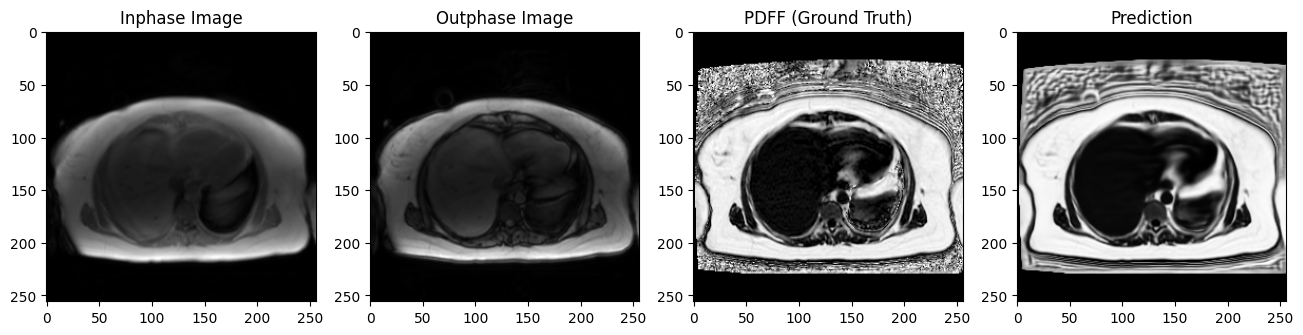

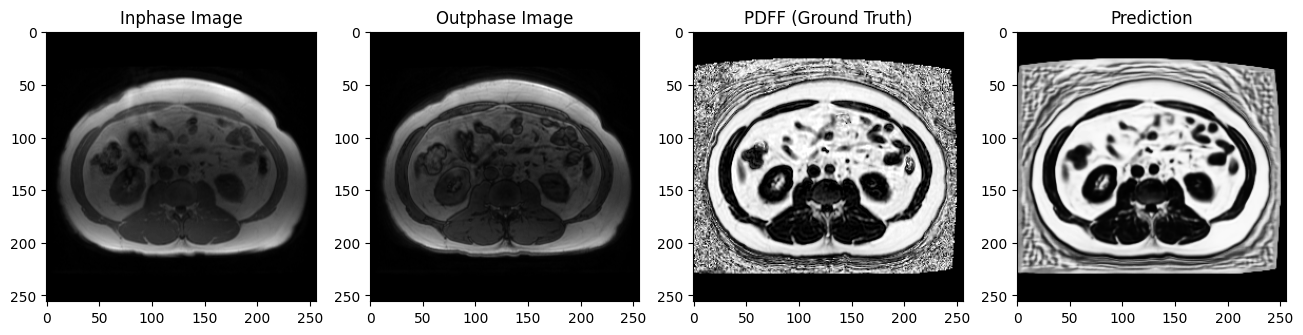

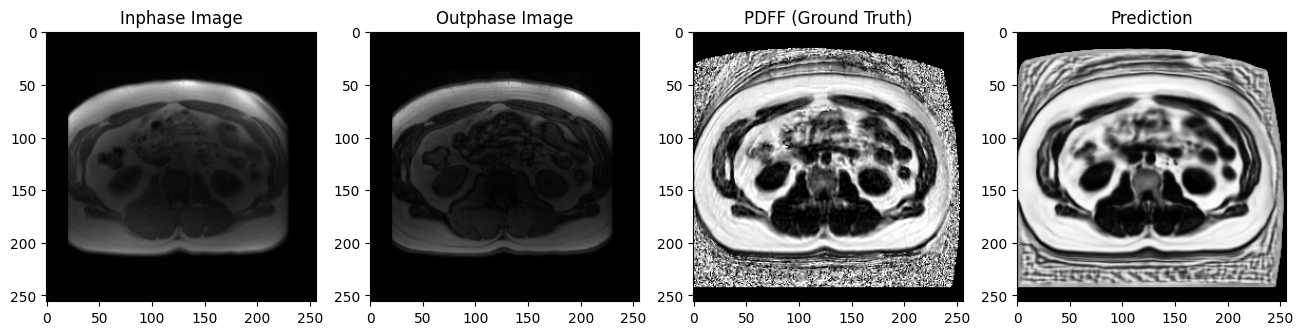

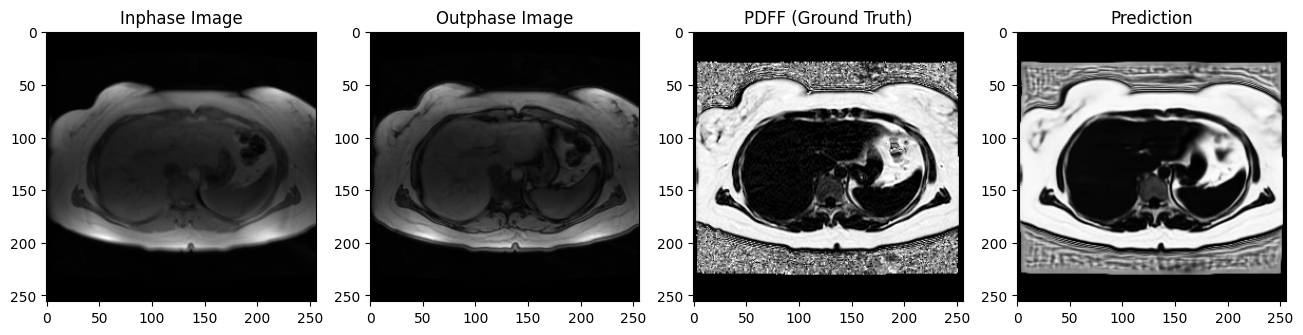

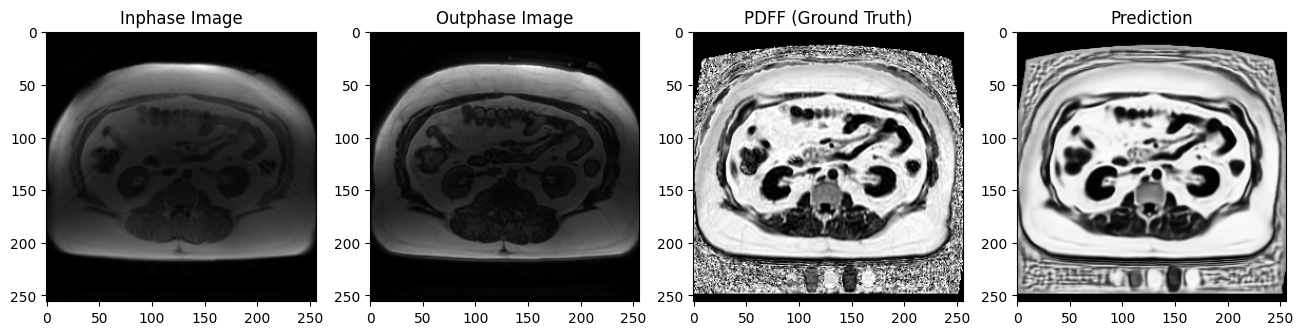

In [275]:
for z in range(5):
    test_img_number = random.randint(0, len(predictions)-1)
    test_img = input_dataset[test_img_number]
    ground_truth = sliced_pdff_dataset[test_img_number]
    prediction = predictions[test_img_number]
    original_image_normalized = ground_truth.astype(float) / np.max(ground_truth)
    colored_mask = plt.get_cmap('jet')(prediction / np.max(prediction))
    alpha = 0.5 
    colored_mask[..., 3] = np.where(prediction > 0, alpha, 0)

    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.title('Inphase Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(142)
    plt.title('Outphase Image')
    plt.imshow(test_img[:,:,1], cmap='gray')
    plt.subplot(143)
    plt.title('PDFF (Ground Truth)')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(144)
    plt.title('Prediction')
    plt.imshow(prediction, cmap='gray')
    plt.show()

In [ ]:
num_volumes = np.array(predictions).shape[0] // 104

prediction_volumes = [predictions[i*104:(i+1)*104]  for i in range(num_volumes)]

cropped_prediction_volumes = []

for vol in prediction_volumes:
    cropped_vol = vol[20:84]   # keeps 64 slices
    cropped_prediction_volumes.append(cropped_vol)


In [ ]:
print(prediction_volumes[0].shape)

In [ ]:
dicom_folder = "D:\GEA21/fat\A21_01\FatFrac_IDEAL_IQ_PDFF_11"
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(dicom_folder)
reader.SetFileNames(dicom_names)
dicom_img = reader.Execute()

# Convert SimpleITK image to Nibabel NIfTI
ref_img = sitk.GetImageFromArray(sitk.GetArrayFromImage(dicom_img))  # ensure same image orientation
spacing = dicom_img.GetSpacing()
origin = dicom_img.GetOrigin()
direction = dicom_img.GetDirection()

save_dir = "C:/Users/User\Desktop\inout_pdff\outputs\predictions"
os.makedirs(save_dir, exist_ok=True)

for idx, vol in enumerate(cropped_prediction_volumes):

    vol = np.asarray(vol).astype(np.float32)
    # vol = np.transpose(vol, (1, 2, 0))
    # vol = np.rot90(vol, k=-1, axes=(0,1))
    # vol = np.flip(vol, axis=0)
    # Optional: only rescale to match training PDFF range
    vol = np.clip(vol * 100, 0, 100)

    # Convert to NIfTI using SimpleITK
    sitk_vol = sitk.GetImageFromArray(vol)  # keeps (Z,H,W) order
    sitk_vol.SetSpacing(spacing)
    sitk_vol.SetOrigin(origin)
    sitk_vol.SetDirection(direction)

    # Save to NIfTI
    out_path = os.path.join(save_dir, f"{pdff_names[idx]}.nii")
    sitk.WriteImage(sitk_vol, out_path)

In [ ]:
print(pdff_volumes[0])
prediction_volumes_64 = []

for vol in cropped_prediction_volumes:
    # vol is still a list of 2D slices: length 64
    vol_array = np.asarray(vol)           # shape: (64, H, W)
    vol_array = np.transpose(vol_array, (1, 2, 0))  # now (H, W, 64)
    prediction_volumes_64.append(vol_array.astype(np.float32))

pdff_volumes_cropped = []

crop_start = 20
crop_end = 84   # keep 64 slices

for vol in pdff_volumes:
    # vol.shape = (104, H, W)
    cropped_vol = vol[crop_start:crop_end, :, :]  # (64, H, W)
    # Optionally reorder to (H, W, S) to match your predictions
    cropped_vol = np.transpose(cropped_vol, (1, 2, 0))  # now (H, W, 64)
    pdff_volumes_cropped.append(cropped_vol.astype(np.float32))

In [ ]:
print(prediction_volumes_64[0].shape)
print(pdff_volumes_cropped[0].shape)

In [ ]:
# pdff_vol = pdff_volumes_cropped[0]  # shape: (H, W, 64)
# seg_vol = prediction_volumes_64[0]  # or full liver segmentation (H, W, 64)

# # Choose a few slice indices to check
# slice_indices = [20, 32, 45]  # pick 3 slices within 0-63

# for i in slice_indices:
#     plt.figure(figsize=(12,6))
#     # PDFF slice
#     plt.subplot(121)
#     plt.imshow(pdff_vol[:, :, i], cmap='gray')
#     plt.title(f'PDFF Slice {i}')
#     plt.axis('off')

#     # PDFF slice with segmentation overlay (optional)
#     plt.subplot(122)
#     plt.imshow(pdff_vol[:, :, i], cmap='gray')
#     if seg_vol is not None:
#         plt.imshow(seg_vol[:, :, i], alpha=0.3, cmap='Reds')
#     plt.title(f'PDFF Slice {i} with segmentation')
#     plt.axis('off')

#     plt.show()

In [ ]:
fat_segmentations_directory = "D:\GEA21/fat_segmentations/"
pred_segmentations_directory = "D:/GEA21/pred_segmentations/"

fat_segmentations = sorted(os.listdir(fat_segmentations_directory))
pred_segmentations = sorted(os.listdir(pred_segmentations_directory))

pred_seg_middle_slices = []
pdff_seg_middle_slices = []
pred_middle_slices = []
pdff_middle_slices = []


for i in range(len(fat_segmentations)):
    fat_seg = nib.load(fat_segmentations_directory + fat_segmentations[i]).get_fdata()
    pred_seg = nib.load(pred_segmentations_directory + pred_segmentations[i]).get_fdata()

    fat_seg = (fat_seg > 0).astype(np.uint8)
    pred_seg = (pred_seg > 0).astype(np.uint8)

    slice_sums = np.sum(fat_seg, axis=(0,1))
    first_slice = np.argmax(slice_sums > 0)
    last_slice = len(slice_sums) - 1 - np.argmax(slice_sums[::-1] > 0)

    middle_idx = (first_slice + last_slice) // 2
    start_idx = max(middle_idx - 1, first_slice)
    end_idx = min(middle_idx + 2, last_slice + 1)
    
    middle_slices_fat_seg = fat_seg[:, :, start_idx:end_idx]
    middle_slices_pred_seg = pred_seg[:,:,start_idx:end_idx]

    middle_slices_pred = prediction_volumes_64[i][:, :, start_idx:end_idx]
    middle_slices_fat = pdff_volumes_cropped[i][:, :, start_idx:end_idx]

    pred_seg_middle_slices.append(middle_slices_pred_seg)
    pdff_seg_middle_slices.append(middle_slices_fat_seg)

    pred_middle_slices.append(middle_slices_pred)
    pdff_middle_slices.append(middle_slices_fat)

In [ ]:
print(len(pred_middle_slices))
print(len(pdff_middle_slices))
print(len(pred_seg_middle_slices))
print(len(pdff_seg_middle_slices))
print(np.array(pred_middle_slices[0]).shape)
print(np.array(pdff_middle_slices[0]).shape)
print(np.array(pred_seg_middle_slices[0]).shape)
print(np.array(pdff_seg_middle_slices[0]).shape)

In [ ]:
print(fat_segmentations[0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for volume_idx in range(len(pdff_middle_slices)):
    # Grab middle slices for this volume
    gt_pdff = pdff_middle_slices[volume_idx]      # (H, W, 3)
    gt_seg = np.rot90(pdff_seg_middle_slices[volume_idx], k=1)   # (H, W, 3)
    pred_pdff = pred_middle_slices[volume_idx]    # (H, W, 3)
    pred_seg = np.flip(np.rot90(pred_seg_middle_slices[volume_idx], k=1), axis=0) # (H, W, 3)

    i = 1  # choose the first middle slice (0-based indexing: 0,1,2 -> middle is index 1)
    # print(pdff_names[volume_idx], fat_segmentations[volume_idx], pred_segmentations[volume_idx])
    plt.figure(figsize=(12, 6))
    
    # GT PDFF + GT segmentation
    plt.subplot(1, 2, 1)
    plt.imshow(gt_pdff[:, :, i], cmap='gray')
    plt.imshow(pred_seg[:, :, i], cmap='Reds', alpha=0.3)
    plt.title(pdff_names[volume_idx])
    plt.axis('off')
    
    # Pred PDFF + Pred segmentation
    plt.subplot(1, 2, 2)
    plt.imshow(pred_pdff[:, :, i], cmap='gray')
    plt.imshow(pred_seg[:, :, i], cmap='Reds', alpha=0.3)
    plt.title(f'Pred PDFF + Seg Volume {volume_idx} Slice {i}')
    plt.axis('off')
    
    plt.show()


In [ ]:
np.max(np.array(pdff_middle_slices[0]))

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

for i in range(len(pred_middle_slices)):
    center = (70, 140)  # (x, y) format
    radius = 15         # radius of the circle

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    for j in range(3):
        # Convert slice to uint8 image if necessary
        img = pred_middle_slices[i][:,:,j]
        pdff = pdff_middle_slices[i][:,:,j]
        

        # Normalize if it's float or not in [0, 255]
        if img.dtype != np.uint8:
            img = (img - img.min()) / (img.max() - img.min()) * 255
            img = img.astype(np.uint8)

        if pdff.dtype != np.uint8:
            pdff = (pdff - pdff.min()) / (pdff.max() - pdff.min()) * 255
            pdff = pdff.astype(np.uint8)

        # Convert to BGR to draw colored circle (if needed), or stay in grayscale
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        pdff_color = cv2.cvtColor(pdff, cv2.COLOR_GRAY2BGR)


        # Draw the circle on the image
        cv2.circle(img_color, center, radius, (0, 0, 255), thickness=1)  # Red circle (BGR)
        cv2.circle(pdff_color, center, radius, (0, 0, 255), thickness=1)

        # Display
        axs[0][j].imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))  # Convert to RGB for matplotlib
        axs[0][j].set_title(f"Slice {j} with Circle")
        axs[0][j].axis('on')

        axs[1][j].imshow(cv2.cvtColor(pdff_color, cv2.COLOR_BGR2RGB))  # Convert to RGB for matplotlib
        axs[1][j].set_title(f"Slice {j} with Circle")
        axs[1][j].axis('on')

    plt.tight_layout()
    plt.show()


In [253]:
pdff_values = []
prediction_values = []

center = (70, 140)  # (x, y) format
radius = 5         # radius of the circle

circle_mask = np.zeros((256, 256), dtype=np.uint8)
cv2.circle(circle_mask, center, radius, 1, thickness=-1)

for i in range(len(pdff_middle_slices)):
    if i==44:
        print(f"Skipping volume {i} because it has an empty GT mask")
        continue    
    pdff_stats = []
    prediction_stats = []
    for j in range(3):
        gt_seg_aligned = np.rot90(pdff_seg_middle_slices[i][:,:,j], k=1)
        pred_seg_aligned = np.flip(np.rot90(pred_seg_middle_slices[i][:,:,j], k=1), axis=0)
        pdff_stats.append((pdff_middle_slices[i][:,:,j] * pred_seg_aligned))
        prediction_stats.append(((pred_middle_slices[i][:,:,j]) * pred_seg_aligned))
    pdff_values.append(pdff_stats)
    prediction_values.append(prediction_stats)

# for i in range(len(pdff_middle_slices)):  
#     pdff_stats = []
#     prediction_stats = []
#     for j in range(3):
#         pdff_stats.append((pdff_middle_slices[i][:,:,j] * circle_mask))
#         prediction_stats.append(((pred_middle_slices[i][:,:,j]) * circle_mask))
#     pdff_values.append(pdff_stats)
#     prediction_values.append(prediction_stats)



Skipping volume 44 because it has an empty GT mask


In [254]:
pdff_stats = []
prediction_stats = []

for i in range(len(pdff_values)):
    combined_pdff =  np.concatenate(pdff_values[i])
    non_zero_pdff = combined_pdff[combined_pdff != 0]
    mean_non_zero_pdff = np.mean(non_zero_pdff)
    std_non_zero_pdff = np.std(non_zero_pdff)

    combined_pred = np.concatenate(prediction_values[i])
    non_zero_pred = combined_pred[combined_pred != 0]
    mean_non_zero_pred = np.mean(non_zero_pred)
    std_non_zero_pred = np.std(non_zero_pred)

    pdff_stats.append([mean_non_zero_pdff, std_non_zero_pdff])
    prediction_stats.append([mean_non_zero_pred, std_non_zero_pred])

In [255]:
differences = []

for i in range(len(pdff_stats)):
    difference = np.abs(pdff_stats[i][0] - prediction_stats[i][0])
    differences.append(difference)

np.mean(differences)

0.0060780547

In [256]:
pdff_stats = np.array(pdff_stats)
prediction_stats = np.array(prediction_stats)

pdff_mean_values = pdff_stats[:, 0]  
pdff_std_values = pdff_stats[:, 1] 
pred_mean_values = prediction_stats[:, 0] 
pred_std_values = prediction_stats[:, 1]   

In [257]:
data = {
    'PDFF Mean': pdff_mean_values,
    'PDFF STD': pdff_std_values,
    'Prediction Mean': pred_mean_values,
    'Prediction STD': pred_std_values,
    'Difference (PDFF- Prediction)': differences
}

df = pd.DataFrame(data)
df

,PDFF Mean,PDFF STD,Prediction Mean,Prediction STD,Difference (PDFF- Prediction)
0,0.163261,0.047820,0.163938,0.041257,0.000676
1,0.099640,0.037555,0.097533,0.029131,0.002107
2,0.095715,0.038670,0.094317,0.028760,0.001398
3,0.155263,0.035438,0.156305,0.033813,0.001042
4,0.077527,0.034882,0.071749,0.031301,0.005779
...,...,...,...,...,...
77,0.049412,0.036476,0.034720,0.023451,0.014692
78,0.051885,0.046219,0.040564,0.034232,0.011320
79,0.042053,0.038655,0.027935,0.024222,0.014118
80,0.044189,0.048574,0.030253,0.037742,0.013936


In [258]:
df.to_excel("iop_output.xlsx", index=False, sheet_name="Stats")

In [272]:
circle_5_df = pd.read_excel("iop_output_circle_5.xlsx")
circle_10_df = pd.read_excel("iop_output_circle_10.xlsx")
circle_15_df = pd.read_excel("iop_output_circle_15.xlsx")

total_seg_df = pd.read_excel("iop_output.xlsx")

total_seg_df
print(total_seg_df.to_string())

    PDFF Mean  PDFF STD  Prediction Mean  Prediction STD  Difference (PDFF- Prediction)
0    0.163261  0.047820         0.163938        0.041257                       0.000676
1    0.099640  0.037555         0.097533        0.029131                       0.002107
2    0.095715  0.038670         0.094317        0.028760                       0.001398
3    0.155263  0.035438         0.156305        0.033813                       0.001042
4    0.077527  0.034882         0.071749        0.031301                       0.005779
5    0.076477  0.032981         0.073364        0.024026                       0.003112
6    0.176759  0.063166         0.175735        0.052342                       0.001024
7    0.063210  0.034708         0.063072        0.028450                       0.000137
8    0.197918  0.068507         0.196304        0.066627                       0.001615
9    0.041088  0.028630         0.036312        0.018166                       0.004776
10   0.071871  0.034133         

In [260]:
circle_5_mean_diff = circle_5_df['Difference (PDFF- Prediction)'].mean()
circle_10_mean_diff = circle_10_df['Difference (PDFF- Prediction)'].mean()
circle_15_mean_diff = circle_15_df['Difference (PDFF- Prediction)'].mean()

total_seg_mean_diff = total_seg_df['Difference (PDFF- Prediction)'].mean()

circle_5_std_diff = circle_5_df['Difference (PDFF- Prediction)'].std()
circle_10_std_diff = circle_10_df['Difference (PDFF- Prediction)'].std()
circle_15_std_diff = circle_15_df['Difference (PDFF- Prediction)'].std()

total_seg_std_diff = total_seg_df['Difference (PDFF- Prediction)'].std()

print("Circle Radius 5 Mean Difference: ", circle_5_mean_diff, "STD: ", circle_5_std_diff)
print("Circle Radius 10 Mean Difference: ", circle_10_mean_diff, "STD: ", circle_10_std_diff)
print("Circle Radius 15 Mean Difference: ", circle_15_mean_diff, "STD: ", circle_15_std_diff)
print("Total Segmenter Mean Difference: ", total_seg_mean_diff, "STD: ", total_seg_std_diff)

Circle Radius 5 Mean Difference:  0.008012463944593826 STD:  0.009326870491637822
Circle Radius 10 Mean Difference:  0.007442424735839826 STD:  0.011550533477162284
Circle Radius 15 Mean Difference:  0.007834402148623064 STD:  0.012127219279489681
Total Segmenter Mean Difference:  0.0060780546968666515 STD:  0.006058678179736196


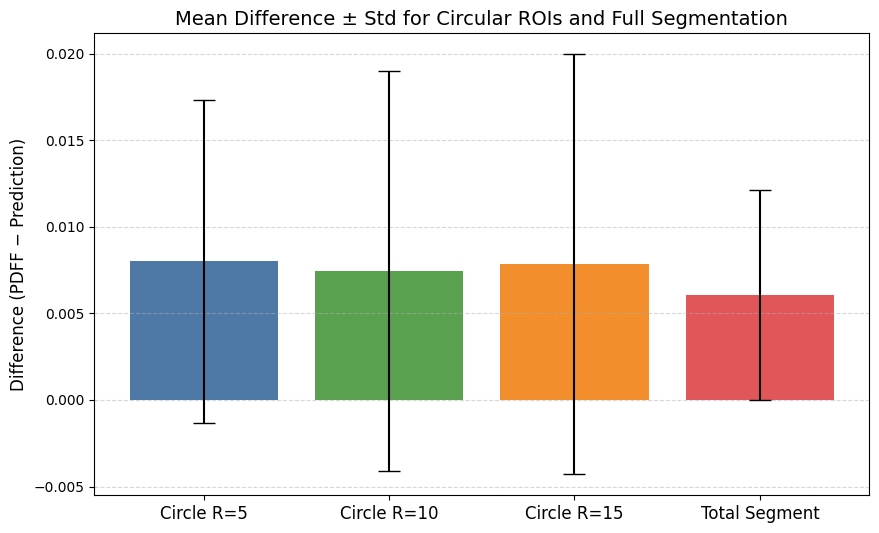

In [261]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and values
labels = ['Circle R=5', 'Circle R=10', 'Circle R=15', 'Total Segment']
means = [
    circle_5_mean_diff,
    circle_10_mean_diff,
    circle_15_mean_diff,
    total_seg_mean_diff
]
stds = [
    circle_5_std_diff,
    circle_10_std_diff,
    circle_15_std_diff,
    total_seg_std_diff
]

x = np.arange(len(labels))

plt.figure(figsize=(10, 6))

# Bar plot with standard deviation error bars
plt.bar(x, means, yerr=stds, capsize=8, color=['#4e79a7','#59a14f','#f28e2b','#e15759'])

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Difference (PDFF − Prediction)", fontsize=12)
plt.title("Mean Difference ± Std for Circular ROIs and Full Segmentation", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [264]:
all_dfs = [circle_5_df, circle_10_df, circle_15_df, total_seg_df]

# Compute global x limits (means)
all_means = np.concatenate([
    (df['PDFF Mean'] + df['Prediction Mean']) / 2 for df in all_dfs
])
xmin, xmax = all_means.min(), all_means.max()

# Compute global y limits (differences)
all_diffs = np.concatenate([
    df['PDFF Mean'] - df['Prediction Mean'] for df in all_dfs
])
ymin, ymax = all_diffs.min(), all_diffs.max()

# Add some padding
xpad = (xmax - xmin) * 0.05
ypad = (ymax - ymin) * 0.05

xlim = (xmin - xpad, xmax + xpad)
ylim = (ymin - ypad, ymax + ypad)


import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(df, title, xlim=None, ylim=None):
    gt = df['PDFF Mean']
    pred = df['Prediction Mean']
    diff = gt - pred
    mean_vals = (gt + pred) / 2

    mean_diff = diff.mean()
    std_diff = diff.std()

    upper = mean_diff + 1.96 * std_diff
    lower = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(7, 6))
    plt.scatter(mean_vals, diff, alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean diff = {mean_diff:.3f}")
    plt.axhline(upper, color='gray', linestyle='--', label=f"+1.96 SD = {upper:.3f}")
    plt.axhline(lower, color='gray', linestyle='--', label=f"-1.96 SD = {lower:.3f}")
    plt.xlabel("Mean of PDFF and Prediction")
    plt.ylabel("Difference (PDFF - Prediction)")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.show()


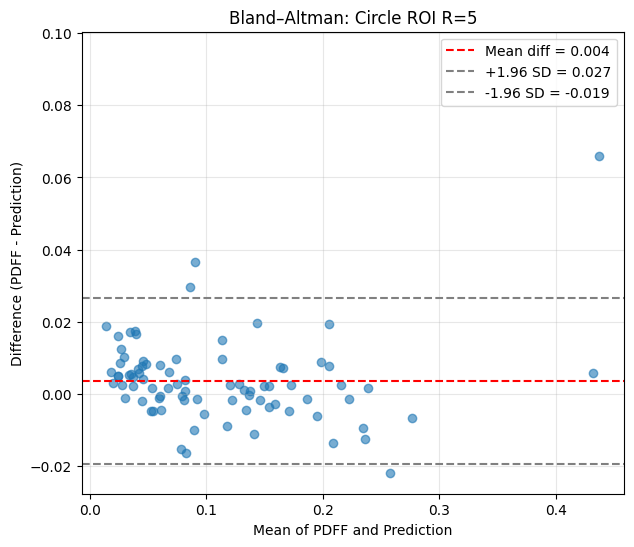

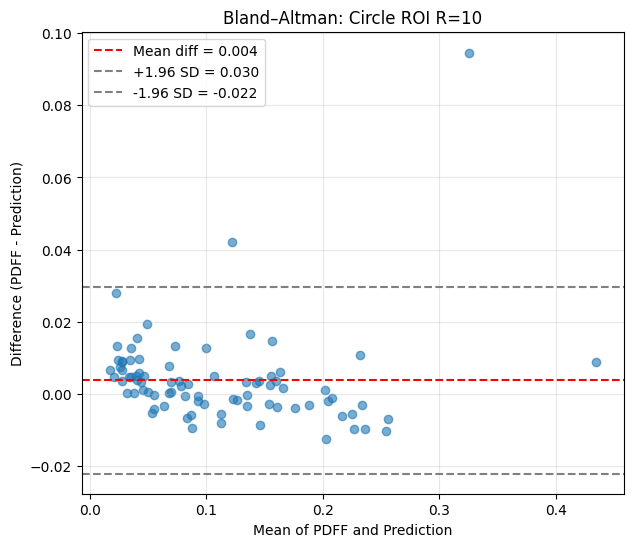

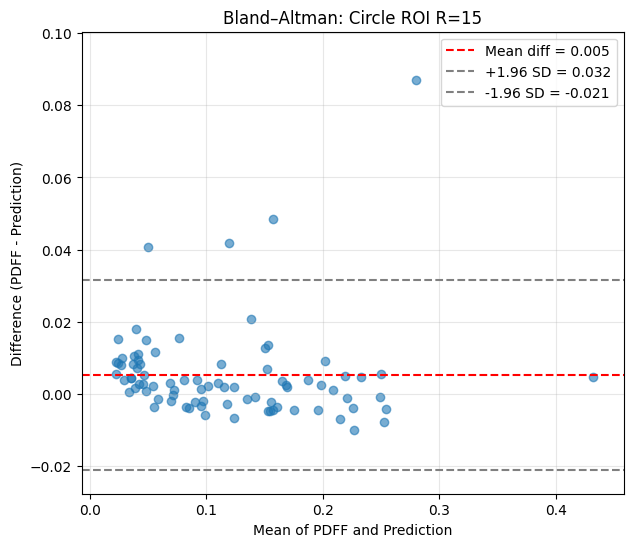

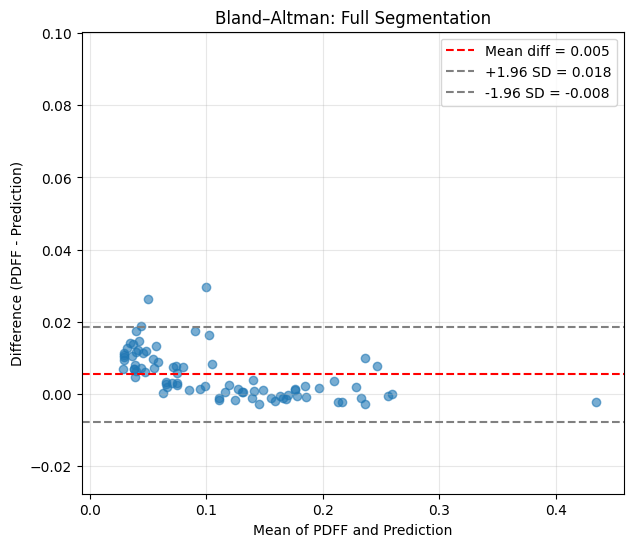

In [265]:
bland_altman_plot(circle_5_df, "Bland–Altman: Circle ROI R=5", xlim=xlim, ylim=ylim)
bland_altman_plot(circle_10_df, "Bland–Altman: Circle ROI R=10", xlim=xlim, ylim=ylim)
bland_altman_plot(circle_15_df, "Bland–Altman: Circle ROI R=15", xlim=xlim, ylim=ylim)
bland_altman_plot(total_seg_df, "Bland–Altman: Full Segmentation", xlim=xlim, ylim=ylim)
